# import important library

In [1]:
!pip install pandas transformers torch hazm cleantext parsivar

  Using cached numpy-1.24.3-cp310-cp310-win_amd64.whl (14.8 MB)


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.19.0 requires numpy<2.2.0,>=1.26.0, but you have numpy 1.24.3 which is incompatible.
You should consider upgrading via the 'C:\Users\alireza\Desktop\hazm_project\hazm-env\Scripts\python.exe -m pip install --upgrade pip' command.


In [ ]:
import numpy as np 
import pandas as pd 
import re, emoji
import gc
import pandas as pd
import matplotlib.pyplot as plt
import hazm
from cleantext import clean
from transformers import AutoTokenizer, AutoModel, BertModel,BertTokenizer,AutoConfig
import torch
import os
import itertools
import torch.optim as optim
from tensorflow.keras import callbacks
from tensorflow.keras.callbacks import CSVLogger
from tensorflow.keras.optimizers import Adam, SGD
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_recall_fscore_support
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, LSTM
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

c:\Users\alireza\Desktop\hazm_project\hazm-env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
pip install tensorflow

  Using cached numpy-2.1.3-cp310-cp310-win_amd64.whl (12.9 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.24.3
    Uninstalling numpy-1.24.3:
      Successfully uninstalled numpy-1.24.3
Note: you may need to restart the kernel to use updated packages.


ERROR: Could not install packages due to an OSError: [WinError 5] Access is denied: 'C:\\Users\\alireza\\Desktop\\hazm_project\\hazm-env\\Lib\\site-packages\\~.mpy\\.libs\\libopenblas64__v0.3.21-gcc_10_3_0.dll'
Check the permissions.

You should consider upgrading via the 'c:\Users\alireza\Desktop\hazm_project\hazm-env\Scripts\python.exe -m pip install --upgrade pip' command.


# preprocessing

## Checking how imbalanced the dataset is.

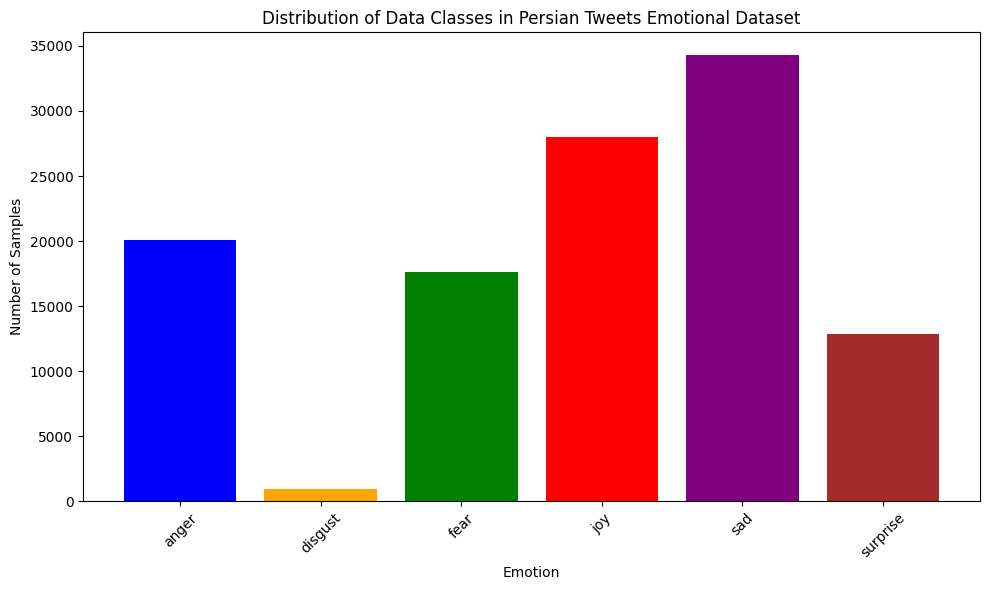

In [ ]:
folder_path = r'C:\Users\alireza\Desktop\hazm_project\persian-tweets-emotional-dataset (1)'

class_counts = {}

for filename in os.listdir(folder_path):
    if filename.endswith('.csv'):
        emotion = os.path.splitext(filename)[0] 
        file_path = os.path.join(folder_path, filename)
        df = pd.read_csv(file_path)
        class_counts[emotion] = len(df)

plt.figure(figsize=(10, 6))
plt.bar(class_counts.keys(), class_counts.values(), color=['blue', 'orange', 'green', 'red', 'purple', 'brown'])
plt.xlabel('Emotion')
plt.ylabel('Number of Samples')
plt.title('Distribution of Data Classes in Persian Tweets Emotional Dataset')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


## 

In [ ]:
normalizer = hazm.Normalizer()
stemmer = hazm.Stemmer()
tokenizer = hazm.WordTokenizer()

def cleanhtml(raw_html):
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, '', raw_html)

    return cleantext

def removeDuplicateCharacters(input):

    regex = r'(.)\1+'

    return re.sub(regex, r'\1', input, flags=re.IGNORECASE)


def clean_urls(text):
    url_pattern = re.compile(r'http\S+|www\S+|https\S+')

    return url_pattern.sub(r'', text)


def replace_emojis(text):

    emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"
        u"\U0001F300-\U0001F5FF"
        u"\U0001F680-\U0001F6FF"
        u"\U0001F1E0-\U0001F1FF"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u'\U00010000-\U0010ffff'
        u"\u200d"
        u"\u2640-\u2642"
        u"\u2600-\u2B55"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\u3030"
        u"\ufe0f"
        u"\u2069"
        u"\u2066"
        u"\u2068"
        u"\u2067"
        "]+", flags=re.UNICODE)


    def emoji_to_text(match):
        emoji_unicode = match.group(0)
        emoji_text = emoji.demojize(emoji_unicode,language = 'fa')
        return emoji_text

    text = emoji_pattern.sub(emoji_to_text, text)
    return text

def remove_stopwords(text):

    stopwords = set(hazm.stopwords_list())
    words = tokenizer.tokenize(text)
#     print("stopwords cleaned")
    return ' '.join([word for word in words if word not in stopwords])

def stemming(text):

    words = tokenizer.tokenize(text)
    stemmed_words = [stemmer.stem(word) for word in words]
#     print("stemming done")
    return ' '.join(stemmed_words)

def clean_text_pipeline(text):

    text = cleanhtml(text)
    text = clean_urls(text)
    text = replace_emojis(text)
    text = removeDuplicateCharacters(text)
    text = remove_stopwords(text)
#     text = stemming(text)
    text = normalizer.normalize(text)
    return text

## example clean_urls

In [163]:
filename = os.listdir(folder_path)
print(filename[5])
file_path = os.path.join(folder_path, filename[5])
df = pd.read_csv(file_path)
print("raw data")

i=4
text = df.iloc[i,0]
print(text)
print("*"*100)
print(clean_urls(text))


surprise.csv
raw data
میخوای معنی #رفیق و بدونی؟!
کار دیشب آقا کریم مصداق بارز یه رفیقه
وقتی هیچکس حواسش بهت نیس هواتو داره...
از این رفیقا براتون🤍🤝🏻 https://t.co/7Q0NaTMcTC
****************************************************************************************************
میخوای معنی #رفیق و بدونی؟!
کار دیشب آقا کریم مصداق بارز یه رفیقه
وقتی هیچکس حواسش بهت نیس هواتو داره...
از این رفیقا براتون🤍🤝🏻 


## example replace_emojis

In [165]:
filename = os.listdir(folder_path)
print(filename[5])
file_path = os.path.join(folder_path, filename[5])
df = pd.read_csv(file_path)
print("raw data")

i=0
text = df.iloc[i,0]
print(text)
print("*"*100)
print(replace_emojis(text))


surprise.csv
raw data
 نمیدونم چی قبول شدی ولی اییییییوللللللل فاااایتیییینگ من بهت افتخار میکنم مونببه گوگولی🥳🥳
 #monstax
****************************************************************************************************
 نمیدونم چی قبول شدی ولی اییییییوللللللل فاااایتیییینگ من بهت افتخار میکنم مونببه گوگولی:جشن_و_سور::جشن_و_سور:
 #monstax


## example removeDuplicateCharacters

In [167]:
filename = os.listdir(folder_path)
print(filename[5])
file_path = os.path.join(folder_path, filename[5])
df = pd.read_csv(file_path)
print("raw data")

i=0
text = df.iloc[i,0]
print(text)
print("*"*100)
print(removeDuplicateCharacters(text))


surprise.csv
raw data
 نمیدونم چی قبول شدی ولی اییییییوللللللل فاااایتیییینگ من بهت افتخار میکنم مونببه گوگولی🥳🥳
 #monstax
****************************************************************************************************
 نمیدونم چی قبول شدی ولی ایول فایتینگ من بهت افتخار میکنم مونبه گوگولی🥳
 #monstax


## example remove_stopwords

In [169]:
filename = os.listdir(folder_path)
print(filename[5])
file_path = os.path.join(folder_path, filename[5])
df = pd.read_csv(file_path)
print("raw data")

i=1
text = df.iloc[i,0]
print(text)
print("*"*100)
print(remove_stopwords(text))

surprise.csv
raw data
    اصلا نگران نباش همه رو یاد میگیری روزای اول ک مامانت هست کمکت میکنه و بهت یاد میده بعدم ک دیگه یاد گرفتی بهترینو براش انجام میدی 😍😍
D.O.
#엑소 #디오 
 
 

****************************************************************************************************
اصلا نگران نباش یاد میگیری روزای ک مامان ##ت هست کمک ##ت میکنه بهت یاد میده ##م ک دیگه یاد گرفتی ##و براش انجام میدی [UNK] D . O . [UNK] [UNK] [UNK] [UNK]


## example stemming

In [182]:


filename = os.listdir(folder_path)
print(filename[5])
file_path = os.path.join(folder_path, filename[5])
df = pd.read_csv(file_path)
print("raw data")

i=10
text = df.iloc[i,0]
print(text)
print("*"*100)
print(stemming(text))

surprise.csv
raw data
وای وای هر وقت بهت نیاز دارم پیدات میشه میخوام برات بمیرم حونمیوننننن

#DONT_FIGHT_THE_FEELING
#EXO #엑소 
  https://t.co/ww8Sqno3yP https://t.co/gV953D1PuW
****************************************************************************************************
وا وا هر وق به نیاز دار پیدا ## میشه میخوا بر بمیر حو ##نم ##ونن ##نن ##ن [UNK] DO ##NT _ FI ##G ##HT _ TH ##E _ FE ##EL ##ING [UNK] EX ##O [UNK] [UNK] https : / / t . co / w ##w ##8 ##S ##q ##n ##o ##3 ##y ##P https : / / t . co / g ##V ##95 ##3 ##D ##1 ##P ##u ##W


In [183]:
filename = os.listdir(folder_path)
print(filename[0])
file_path = os.path.join(folder_path, filename[0])
df = pd.read_csv(file_path)
print("raw data")
for i in range(df.shape[0]):
    text = df.iloc[i,0]
    # print(text)
    # print("*"*100)
    # print(cleanhtml(text))
    if clean_urls(text)!=text:
        # print("same")
        print(i)



anger.csv
raw data
3
6
9
16
21
22
23
25
30
34
37
39
40
44
48
56
58
60
63
64
65
66
67
68
69
75
86
101
103
118
120
122
130
131
132
137
142
145
155
156
160
161
162
165
168
171
172
173
175
176
177
178
179
182
185
186
189
190
192
194
198
200
201
208
209
212
214
217
218
219
220
221
222
225
226
227
228
230
236
237
238
241
243
245
246
247
248
249
250
253
255
259
260
270
271
272
273
274
276
279
282
283
284
286
287
288
289
290
291
292
294
296
302
306
313
317
318
321
323
324
329
332
333
334
341
342
343
348
351
359
360
364
369
371
373
374
375
376
378
379
380
381
383
385
388
389
404
405
410
412
423
425
426
428
431
432
434
441
442
443
445
446
447
448
449
451
456
465
466
467
470
472
473
474
479
482
489
491
492
494
500
501
506
509
513
517
519
521
522
525
536
537
540
545
547
552
570
571
575
587
588
593
595
598
599
600
601
603
604
606
608
609
611
612
613
614
617
618
619
620
621
622
624
626
631
632
635
636
637
638
639
641
644
645
646
647
649
650
651
653
655
657
659
660
664
666
667
670
671
673
674
675
677

In [ ]:
def load_and_process_data(file_path):

    df = pd.read_csv(file_path)
    df_cleaned = pd.DataFrame()
    df_cleaned['raw tweet'] = df['tweet']
    print("apply cleaning steps")
    df_cleaned['cleaned tweet'] = df['tweet'].apply(clean_text_pipeline)
    df_cleaned['emotion'] = df['emotion']
    return df_cleaned

folder_path = r'C:\Users\alireza\Desktop\hazm_project\persian-tweets-emotional-dataset (1)'

for filename in os.listdir(folder_path):
    emotion = os.path.splitext(filename)[0]
    file_path = os.path.join(folder_path, filename)

    df_output = load_and_process_data(file_path)
    df_output.to_csv(f'C:/Users/alireza/Desktop/hazm_project/persian-tweets-emotional-dataset-new/{emotion}.csv', index=False)

apply cleaning steps
apply cleaning steps
apply cleaning steps
apply cleaning steps
apply cleaning steps
apply cleaning steps


# Tokenizing each tweet with parsebert tokenizer

In [8]:
tokenizer = AutoTokenizer.from_pretrained("HooshvareLab/bert-base-parsbert-uncased")

In [9]:
def tokenize_text(text):
    """Tokenize text and convert tokens to token IDs."""
    tokens = tokenizer.tokenize(text, padding='max_length', truncation=True, max_length=32, return_tensors="pt")
    token_ids = tokenizer.convert_tokens_to_ids(tokens)
    return token_ids

In [ ]:
def load_and_tokenize_data(file_path):
    """Load cleaned data from CSV and tokenize the tweets."""
    df = pd.read_csv(file_path)
    df['token_ids'] = df['cleaned tweet'].apply(tokenize_text)

    return df

In [ ]:
# cleaned_file_paths=r'C:\Users\alireza\Desktop\hazm_project\persian-tweets-emotional-dataset-new'

# for filename in os.listdir(cleaned_file_paths):
    
#     emotion = os.path.splitext(filename)[0]
#     file_path = os.path.join(cleaned_file_paths, filename)

#     df_tokenized = load_and_tokenize_data(file_path)

#     file_name = os.path.basename(file_path)

#     output_file_path = f'C:/Users/alireza/Desktop/hazm_project/persian-tweets-emotional-dataset-tokenized/{emotion}.csv'
#     df_tokenized.to_csv(output_file_path, index=False)

#     print(f"Tokenized {file_path} and saved to {output_file_path}")

Tokenized C:\Users\alireza\Desktop\hazm_project\persian-tweets-emotional-dataset-new\anger.csv and saved to C:/Users/alireza/Desktop/hazm_project/persian-tweets-emotional-dataset-tokenized/anger.csv
Tokenized C:\Users\alireza\Desktop\hazm_project\persian-tweets-emotional-dataset-new\disgust.csv and saved to C:/Users/alireza/Desktop/hazm_project/persian-tweets-emotional-dataset-tokenized/disgust.csv
Tokenized C:\Users\alireza\Desktop\hazm_project\persian-tweets-emotional-dataset-new\fear.csv and saved to C:/Users/alireza/Desktop/hazm_project/persian-tweets-emotional-dataset-tokenized/fear.csv
Tokenized C:\Users\alireza\Desktop\hazm_project\persian-tweets-emotional-dataset-new\joy.csv and saved to C:/Users/alireza/Desktop/hazm_project/persian-tweets-emotional-dataset-tokenized/joy.csv
Tokenized C:\Users\alireza\Desktop\hazm_project\persian-tweets-emotional-dataset-new\sad.csv and saved to C:/Users/alireza/Desktop/hazm_project/persian-tweets-emotional-dataset-tokenized/sad.csv
Tokenized C

In [12]:
model_name = 'HooshvareLab/bert-fa-zwnj-base'
tokenizer = BertTokenizer.from_pretrained(model_name)

In [13]:
# Modifying parsebert config and defining our custom model for word embedding extraction

In [14]:
from transformers import AutoConfig

config = AutoConfig.from_pretrained("HooshvareLab/bert-base-parsbert-uncased")
config.hidden_size = 120
modified_model = AutoModel.from_config(config)

print(modified_model)

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(100000, 120, padding_idx=0)
    (position_embeddings): Embedding(512, 120)
    (token_type_embeddings): Embedding(2, 120)
    (LayerNorm): LayerNorm((120,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=120, out_features=120, bias=True)
            (key): Linear(in_features=120, out_features=120, bias=True)
            (value): Linear(in_features=120, out_features=120, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=120, out_features=120, bias=True)
            (LayerNorm): LayerNorm((120,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=Fals

In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
modified_model.to(device)

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(100000, 120, padding_idx=0)
    (position_embeddings): Embedding(512, 120)
    (token_type_embeddings): Embedding(2, 120)
    (LayerNorm): LayerNorm((120,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=120, out_features=120, bias=True)
            (key): Linear(in_features=120, out_features=120, bias=True)
            (value): Linear(in_features=120, out_features=120, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=120, out_features=120, bias=True)
            (LayerNorm): LayerNorm((120,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=Fals

In [16]:
import pandas as pd

anger_df = pd.read_csv(r'C:\Users\alireza\Desktop\hazm_project\persian-tweets-emotional-dataset-new\anger.csv')
surprise_df = pd.read_csv(r'C:\Users\alireza\Desktop\hazm_project\persian-tweets-emotional-dataset-new\surprise.csv')
joy_df = pd.read_csv(r'C:\Users\alireza\Desktop\hazm_project\persian-tweets-emotional-dataset-new\joy.csv')
sad_df = pd.read_csv(r'C:\Users\alireza\Desktop\hazm_project\persian-tweets-emotional-dataset-new\sad.csv')
disgust_df = pd.read_csv(r'C:\Users\alireza\Desktop\hazm_project\persian-tweets-emotional-dataset-new\disgust.csv')
fear_df = pd.read_csv(r'C:\Users\alireza\Desktop\hazm_project\persian-tweets-emotional-dataset-new\fear.csv')

df_list = [anger_df, surprise_df, joy_df, sad_df, disgust_df, fear_df]

df = pd.concat([anger_df, surprise_df, joy_df, sad_df, disgust_df, fear_df], ignore_index=True)
texts = df['cleaned tweet'].tolist()

In [ ]:
def tokenize_text(text):
    """Tokenize text and convert tokens to token IDs."""
    encoded_input = tokenizer.encode_plus(
        text,
        add_special_tokens=True,
        padding='max_length',
        truncation=True,
        max_length=32,
        return_tensors='pt'
    )
    input_ids = encoded_input['input_ids']
    attention_mask = encoded_input['attention_mask']

    return {
        'input_ids': input_ids.squeeze().tolist(),
        'attention_mask': attention_mask.squeeze().tolist()
    }

In [18]:
def load_and_tokenize_data(df):
    """Tokenize the 'cleaned tweet' column and convert to token IDs."""
    tokenized_data = df['cleaned tweet'].apply(tokenize_text).tolist()

    input_ids = [item['input_ids'] for item in tokenized_data]
    attention_mask = [item['attention_mask'] for item in tokenized_data]

    return torch.tensor(input_ids), torch.tensor(attention_mask)


In [19]:
input_ids_all = []
attention_mask_all = []

for df in df_list:
    print("tokenizing started")
    input_ids, attention_mask = load_and_tokenize_data(df)
    input_ids_all.append(input_ids)
    attention_mask_all.append(attention_mask)

input_ids_all = torch.cat(input_ids_all, dim=0)
attention_mask_all = torch.cat(attention_mask_all, dim=0)

tokenizing started
tokenizing started
tokenizing started
tokenizing started
tokenizing started
tokenizing started


In [20]:
print(input_ids_all.shape)
print(attention_mask_all.shape)

torch.Size([113829, 32])
torch.Size([113829, 32])


In [21]:
def get_embeddings(input_ids, attention_mask, model):
    input_ids = input_ids.to(device)
    attention_mask = attention_mask.to(device)
    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
    embeddings = outputs.last_hidden_state
    return embeddings

In [22]:
def process_in_batches(input_ids, attention_mask, batch_size, model):
    num_batches = len(input_ids) // batch_size + (1 if len(input_ids) % batch_size != 0 else 0)
    all_word_embeddings = []

    for i in range(num_batches):
        start_idx = i * batch_size
        end_idx = min((i + 1) * batch_size, len(input_ids))

        input_ids_batch = input_ids[start_idx:end_idx]
        attention_mask_batch = attention_mask[start_idx:end_idx]

        embeddings = get_embeddings(input_ids_batch, attention_mask_batch, model).to(device)

        all_word_embeddings.append(embeddings)

        del input_ids_batch, attention_mask_batch, embeddings
        gc.collect()
        torch.cuda.empty_cache()

    return torch.cat(all_word_embeddings, dim=0)

In [23]:
batch_size = 32
emotion_embeddings_dict = {}

for emotion in ['anger', 'surprise', 'joy', 'sad', 'disgust', 'fear']:
    emotion_embeddings_dict[emotion] = []

for df, emotion in zip(df_list, ['anger', 'surprise', 'joy', 'sad', 'disgust', 'fear']):
    input_ids, attention_mask = load_and_tokenize_data(df)
    print(f"{emotion} tokenized")
    word_embeddings = process_in_batches(input_ids, attention_mask, batch_size, modified_model)
    print(f"{emotion} embedded")

    if word_embeddings.is_cuda:
        word_embeddings = word_embeddings.cpu()

    word_embeddings_np = word_embeddings.detach().numpy()
    emotion_embeddings_dict[emotion].append(word_embeddings_np)


anger tokenized
anger embedded
surprise tokenized
surprise embedded
joy tokenized
joy embedded
sad tokenized
sad embedded
disgust tokenized
disgust embedded
fear tokenized
fear embedded


In [24]:
print(emotion_embeddings_dict["anger"])

[array([[[ 4.96893495e-01, -4.73921746e-01,  2.80527025e-01, ...,
         -7.33369052e-01, -1.05470228e+00,  5.40801585e-01],
        [ 1.92938641e-01, -8.30235779e-01,  1.67612243e+00, ...,
         -1.44014478e+00,  6.85000539e-01,  1.82972476e-01],
        [-5.71833625e-02, -9.47194621e-02,  1.67558265e+00, ...,
         -2.37569237e+00, -1.52928507e+00,  5.09663284e-01],
        ...,
        [-3.61583419e-02, -2.64347887e+00,  4.59498793e-01, ...,
         -3.40380937e-01,  1.40229166e-02,  4.14038032e-01],
        [ 1.12445986e+00, -4.97062027e-01, -1.00599468e+00, ...,
         -5.47543347e-01,  5.18812418e-01,  1.39607048e+00],
        [-3.54574353e-01, -8.94259691e-01,  6.07384205e-01, ...,
         -7.37154961e-01,  9.31705952e-01, -7.73369491e-01]],

       [[ 6.00834787e-01, -5.24138391e-01, -1.77166149e-01, ...,
         -9.77346301e-01, -7.40535319e-01,  1.16586995e+00],
        [ 3.95244062e-01, -1.89373958e+00,  3.76100987e-01, ...,
         -1.17085338e+00,  1.87530652

now we have word embedding for each token in each sentence, in other words, each tweet is converted into a (32,120) tensor where 32 refers to the number of tokens and the 120 refers to the size of embedding.
# Now we need to define three models namely lstm_cnn, cnn, and lstm. The word embeddings will be passed through these three models.

In [ ]:
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Dense, Dropout, Activation, Lambda, Embedding,
    Conv1D, Conv2D, Flatten, MaxPooling1D, BatchNormalization,
    Input, Reshape, LSTM, GRU, SimpleRNN
)
from tensorflow.keras.datasets import imdb
from tensorflow.keras import backend as K
from tensorflow.keras import callbacks
from tensorflow.keras.callbacks import (
    CSVLogger, ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
)

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import Normalizer
import numpy as np
import pandas as pd
import h5py


# Now we train these three models with our word embeddings

In [31]:
emotion_tensors_dict = {}
for emotion, embeddings_list in emotion_embeddings_dict.items():
    emotion_tensors_dict[emotion] = np.stack(embeddings_list)


for emotion, tensor in emotion_tensors_dict.items():
    emotion_tensors_dict[emotion] = tensor.squeeze(axis=0)

emotion_to_digit = {'anger': 0, 'surprise': 1, 'joy': 2, 'sad': 3, 'disgust': 4, 'fear': 5}

emotion_embeddings = []
emotion_labels = []


for emotion, embeddings in emotion_tensors_dict.items():
    print(embeddings.shape)
    labels = np.full((len(embeddings),), fill_value=emotion_to_digit[emotion])  # Convert emotion labels to digits
    emotion_embeddings.append(embeddings)
    emotion_labels.append(labels)


X = np.concatenate(emotion_embeddings, axis=0)
y = np.concatenate(emotion_labels, axis=0)

print("X shape:", X.shape)
print("y shape:", y.shape)

(20069, 32, 120)
(12859, 32, 120)
(28024, 32, 120)
(34328, 32, 120)
(925, 32, 120)
(17624, 32, 120)
X shape: (113829, 32, 120)
y shape: (113829,)


In [37]:
np.save(r'C:\Users\alireza\Desktop\hazm_project\emotion_embeddings.npy', X)
np.save(r'C:\Users\alireza\Desktop\hazm_project\emotion_labels.npy', y)

In [38]:
X = np.load(r'C:\Users\alireza\Desktop\hazm_project\emotion_embeddings.npy')
y = np.load(r'C:\Users\alireza\Desktop\hazm_project\emotion_labels.npy')

In [39]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.3, shuffle = True)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, shuffle = True)

In [33]:
!pip install scikeras

You should consider upgrading via the 'C:\Users\alireza\Desktop\hazm_project\hazm-env\Scripts\python.exe -m pip install --upgrade pip' command.


# lstm_cnn

Model: "sequential_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_14 (Conv1D)              │ (None, 30, 64)         │        23,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_14 (MaxPooling1D) │ (None, 15, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_15 (LSTM)                  │ (None, 100)            │        66,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 100)            │           400 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 6)              │           606 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 90,110 (351.99 KB)

 Trainable params: 89,910 (351.21 KB)

 Non-trainable params: 200 (800.00 B)

Epoch 1/20
7968/7968 ━━━━━━━━━━━━━━━━━━━━ 100s 12ms/step - accuracy: 0.3198 - loss: 1.6089 - val_accuracy: 0.2945 - val_loss: 2.1813 - learning_rate: 0.0010
Epoch 2/20
7968/7968 ━━━━━━━━━━━━━━━━━━━━ 97s 12ms/step - accuracy: 0.5071 - loss: 1.2423 - val_accuracy: 0.6233 - val_loss: 1.0050 - learning_rate: 0.0010
Epoch 3/20
7968/7968 ━━━━━━━━━━━━━━━━━━━━ 121s 15ms/step - accuracy: 0.6364 - loss: 0.9995 - val_accuracy: 0.6960 - val_loss: 0.8688 - learning_rate: 0.0010
Epoch 4/20
7968/7968 ━━━━━━━━━━━━━━━━━━━━ 120s 15ms/step - accuracy: 0.7101 - loss: 0.8222 - val_accuracy: 0.7579 - val_loss: 0.6969 - learning_rate: 0.0010
Epoch 5/20
7968/7968 ━━━━━━━━━━━━━━━━━━━━ 112s 14ms/step - accuracy: 0.7502 - loss: 0.7241 - val_accuracy: 0.7605 - val_loss: 0.6809 - learning_rate: 0.0010
Epoch 6/20
7968/7968 ━━━━━━━━━━━━━━━━━━━━ 84s 11ms/step - accuracy: 0.7711 - loss: 0.6693 - val_accuracy: 0.7792 - val_loss: 0.6319 - learning_rate: 0.0010
Epoch 7/20
7968/7968 ━━━━━━━━━━━━━━━━━━━━ 100s 13ms/step - a

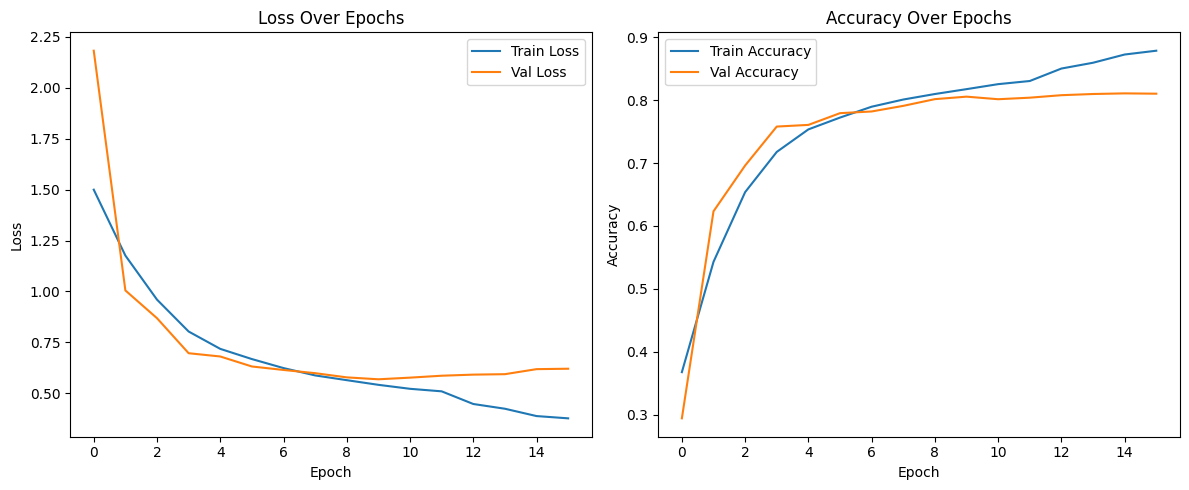

In [90]:
from tensorflow.keras.models import load_model

# Define model
lstm_cnn = Sequential()
lstm_cnn.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(32, 120)))
# lstm_cnn.add(Dropout(0.3))
lstm_cnn.add(MaxPooling1D(pool_size=2))
lstm_cnn.add(LSTM(units=100))
lstm_cnn.add(BatchNormalization())
lstm_cnn.add(Dropout(0.1))
lstm_cnn.add(Dense(units=6, activation='softmax'))


lstm_cnn.summary()

learning_rates = 0.001
batch_size = 8
optimizer = Adam(learning_rate=learning_rates)
opt = 'adam'

lstm_cnn.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=['accuracy'])

callbacks_list = [
    ModelCheckpoint(filepath=f'logs/cnn-lstm/model-{opt}-{learning_rates}-{batch_size}.keras',
                    save_best_only=True, monitor='val_loss', mode='min'),
    EarlyStopping(monitor='val_loss', patience=6, mode='min', verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.4, patience=2, min_lr=0.0001, mode='min', verbose=1)
]

history = lstm_cnn.fit(X_train, y_train, epochs=20, batch_size=batch_size, validation_data=(X_val, y_val),
            verbose=1, shuffle = True, callbacks=callbacks_list)

best_model_lstm_cnn = load_model(f'logs/cnn-lstm/model-{opt}-{learning_rates}-{batch_size}.keras')

loss, accuracy = best_model_lstm_cnn.evaluate(X_test, y_test)
print(f"\nOptimizer: {opt}, Learning Rate: {learning_rates}, Batch Size: {batch_size}")
print("Loss: %.2f, Accuracy: %.2f%%" % (loss, accuracy*100))

hist = history.history

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(hist['loss'], label='Train Loss')
plt.plot(hist['val_loss'], label='Val Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(hist['accuracy'], label='Train Accuracy')
plt.plot(hist['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

1068/1068 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step


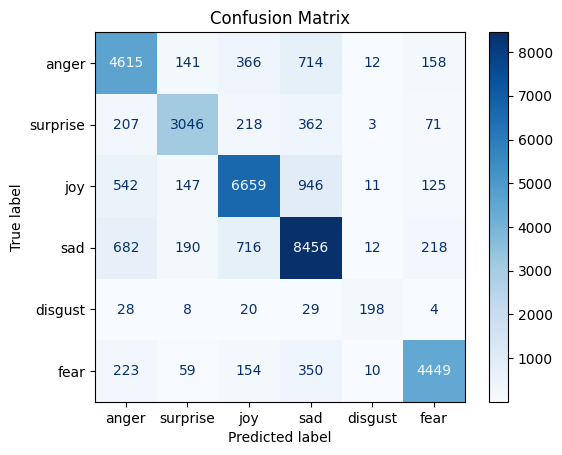

              precision    recall  f1-score   support

           0       0.73      0.77      0.75      6006
           1       0.85      0.78      0.81      3907
           2       0.82      0.79      0.80      8430
           3       0.78      0.82      0.80     10274
           4       0.80      0.69      0.74       287
           5       0.89      0.85      0.87      5245

    accuracy                           0.80     34149
   macro avg       0.81      0.78      0.80     34149
weighted avg       0.81      0.80      0.80     34149



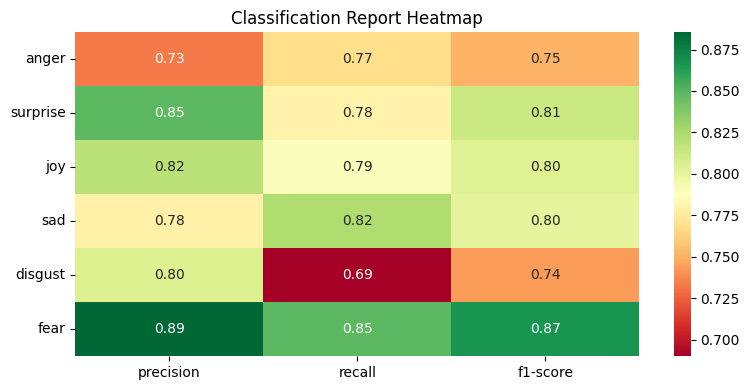

In [88]:
y_pred = lstm_cnn.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

def plot_confusion_matrix(y_test, y_pred_classes):
    cm = confusion_matrix(y_test, y_pred_classes)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(emotion_to_digit.keys()))
    disp.plot(cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.show()

def calculate_metrics(y_test, y_pred_classes):
    metrics = {}
    for avg in ['macro', 'micro', 'weighted']:
        precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred_classes, average=avg)
        accuracy = np.mean(y_pred_classes == y_test)
        metrics[avg] = {
            'precision': round(precision,3),
            'recall': round(recall,3),
            'f1-score': round(f1,3),
            'accuracy': round(accuracy,3)
        }
    return metrics

plot_confusion_matrix(y_test, y_pred_classes)
metrics = calculate_metrics(y_test, y_pred_classes)
print(classification_report(y_test, y_pred_classes))

class_names= ['anger', 'surprise', 'joy', 'sad', 'disgust', 'fear']
report = classification_report(y_test, y_pred_classes, target_names=class_names, output_dict=True)
report_df = pd.DataFrame(report).drop(columns=['accuracy', 'macro avg', 'weighted avg'], errors='ignore').T

plt.figure(figsize=(8, 4))
sns.heatmap(report_df[['precision', 'recall', 'f1-score']], annot=True, cmap='RdYlGn', fmt=".2f", cbar=True)
plt.title('Classification Report Heatmap')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


# lstm

Epoch 1/10
7968/7968 ━━━━━━━━━━━━━━━━━━━━ 98s 12ms/step - accuracy: 0.3361 - loss: 1.5949 - val_accuracy: 0.4785 - val_loss: 1.6022 - learning_rate: 0.0010
Epoch 2/10
7968/7968 ━━━━━━━━━━━━━━━━━━━━ 107s 13ms/step - accuracy: 0.5757 - loss: 1.1179 - val_accuracy: 0.6696 - val_loss: 0.9073 - learning_rate: 0.0010
Epoch 3/10
7968/7968 ━━━━━━━━━━━━━━━━━━━━ 105s 13ms/step - accuracy: 0.6822 - loss: 0.8799 - val_accuracy: 0.7105 - val_loss: 0.8291 - learning_rate: 0.0010
Epoch 4/10
7968/7968 ━━━━━━━━━━━━━━━━━━━━ 102s 13ms/step - accuracy: 0.7382 - loss: 0.7525 - val_accuracy: 0.7559 - val_loss: 0.7153 - learning_rate: 0.0010
Epoch 5/10
7968/7968 ━━━━━━━━━━━━━━━━━━━━ 104s 13ms/step - accuracy: 0.7685 - loss: 0.6853 - val_accuracy: 0.7701 - val_loss: 0.6681 - learning_rate: 0.0010
Epoch 6/10
7968/7968 ━━━━━━━━━━━━━━━━━━━━ 124s 16ms/step - accuracy: 0.7919 - loss: 0.6223 - val_accuracy: 0.7883 - val_loss: 0.6319 - learning_rate: 0.0010
Epoch 7/10
7968/7968 ━━━━━━━━━━━━━━━━━━━━ 125s 16ms/step - 

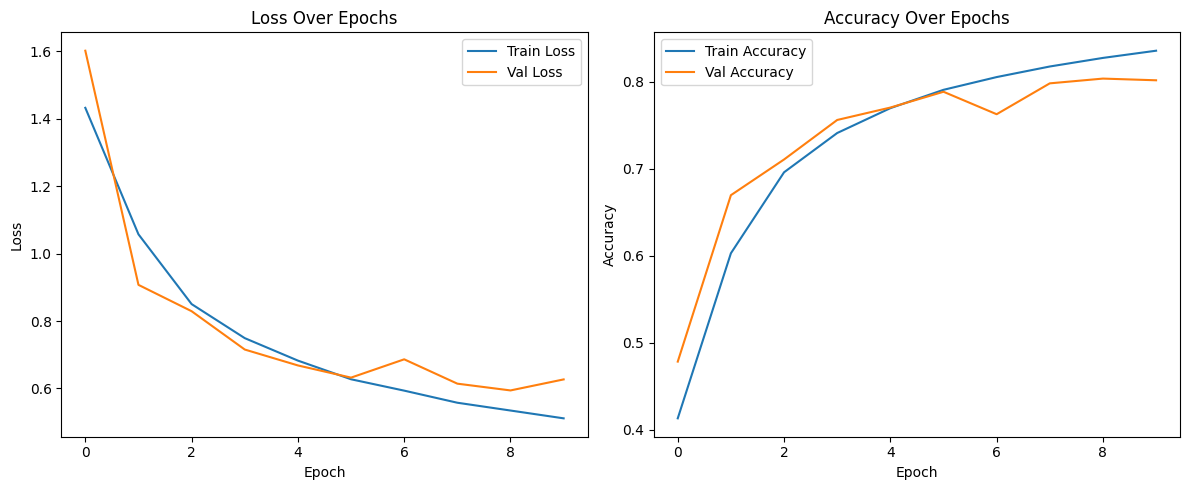

In [84]:
lstm_output_size = 100
lstm = Sequential()
lstm.add(LSTM(lstm_output_size))
lstm.add(BatchNormalization())
lstm.add(Dropout(0.1))
lstm.add(Dense(6, activation="softmax"))

learning_rates = 0.001
batch_size = 8
optimizer = Adam(learning_rate=learning_rates)
opt = 'adam'

lstm.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=['accuracy'])

callbacks_list = [
    ModelCheckpoint(filepath=f'logs/lstm/model-{opt}-{learning_rates}-{batch_size}.keras',
                    save_best_only=True, monitor='val_loss', mode='min'),
    EarlyStopping(monitor='val_loss', patience=6, mode='min', verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.4, patience=2, min_lr=0.0001, mode='min', verbose=1)
]

history2 = lstm.fit(X_train, y_train, epochs=10, batch_size=batch_size, validation_data=(X_val, y_val),
            verbose=1, shuffle = True, callbacks=callbacks_list)

best_model_lstm = load_model(f'logs/lstm/model-{opt}-{learning_rates}-{batch_size}.keras')

loss, accuracy = best_model_lstm.evaluate(X_test, y_test)
print(f"\nOptimizer: {opt}, Learning Rate: {learning_rates}, Batch Size: {batch_size}")
print("Loss: %.2f, Accuracy: %.2f%%" % (loss, accuracy*100))

hist = history2.history

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(hist['loss'], label='Train Loss')
plt.plot(hist['val_loss'], label='Val Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(hist['accuracy'], label='Train Accuracy')
plt.plot(hist['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

1068/1068 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step


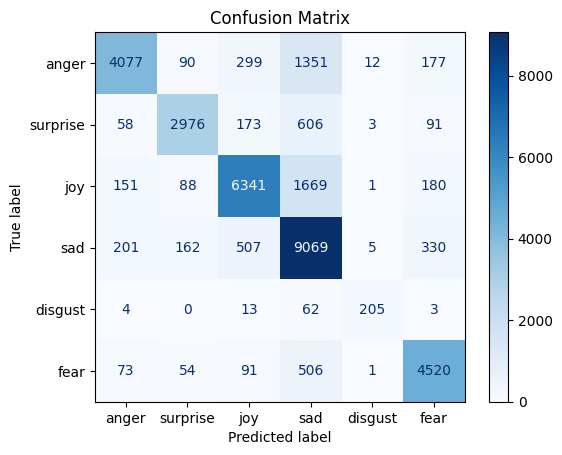

              precision    recall  f1-score   support

           0       0.89      0.68      0.77      6006
           1       0.88      0.76      0.82      3907
           2       0.85      0.75      0.80      8430
           3       0.68      0.88      0.77     10274
           4       0.90      0.71      0.80       287
           5       0.85      0.86      0.86      5245

    accuracy                           0.80     34149
   macro avg       0.85      0.78      0.80     34149
weighted avg       0.81      0.80      0.80     34149



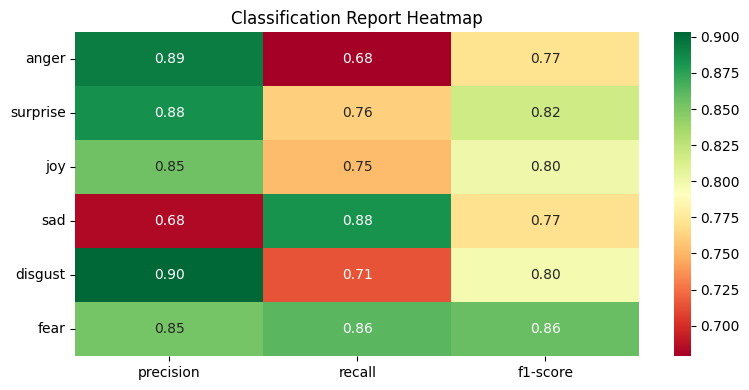

In [85]:
y_pred = lstm.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

plot_confusion_matrix(y_test, y_pred_classes)
print(classification_report(y_test, y_pred_classes))

report = classification_report(y_test, y_pred_classes, target_names=class_names, output_dict=True)
report_df = pd.DataFrame(report).drop(columns=['accuracy', 'macro avg', 'weighted avg'], errors='ignore').T

plt.figure(figsize=(8, 4))
sns.heatmap(report_df[['precision', 'recall', 'f1-score']], annot=True, cmap='RdYlGn', fmt=".2f", cbar=True)
plt.title('Classification Report Heatmap')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# cnn

In [ ]:
cnn = Sequential()
cnn.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(32, 120)))
cnn.add(MaxPooling1D(pool_size=2))
cnn.add(Flatten())
cnn.add(Dense(units=6, activation='softmax'))

for lr in learning_rates:
    for opt in optimizers:
        for batch_size in batch_sizes:

            if opt == 'adam':
                optimizer = Adam(learning_rate=lr)
            elif opt == 'sgd':
                optimizer = SGD(learning_rate=lr)

            cnn.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=['accuracy'])

            callbacks_list = [
                ModelCheckpoint(filepath=f'logs/cnn-lstm/model-{opt}-{lr}-{batch_size}.keras',
                                save_best_only=True, monitor='val_loss', mode='min'),
                EarlyStopping(monitor='val_loss', patience=6, mode='min', verbose=1),
                ReduceLROnPlateau(monitor='val_loss', factor=0.4, patience=2, min_lr=0.0001, mode='min', verbose=1)
            ]


            history3 = cnn.fit(X_train, y_train, epochs=10, batch_size=batch_size, validation_data=(X_val, y_val),
                     verbose=1, shuffle = True, callbacks=callbacks_list)

            loss, accuracy = cnn.evaluate(X_test, y_test)
            print(f"\nOptimizer: {opt}, Learning Rate: {lr}, Batch Size: {batch_size}")
            print("Loss: %.2f, Accuracy: %.2f%%" % (loss, accuracy*100))

Epoch 1/10
7968/7968 ━━━━━━━━━━━━━━━━━━━━ 30s 3ms/step - accuracy: 0.3282 - loss: 1.5740 - val_accuracy: 0.4724 - val_loss: 1.2923 - learning_rate: 0.0010
Epoch 2/10
7968/7968 ━━━━━━━━━━━━━━━━━━━━ 26s 3ms/step - accuracy: 0.5169 - loss: 1.2144 - val_accuracy: 0.6121 - val_loss: 1.0405 - learning_rate: 0.0010
Epoch 3/10
7968/7968 ━━━━━━━━━━━━━━━━━━━━ 26s 3ms/step - accuracy: 0.6281 - loss: 0.9963 - val_accuracy: 0.6644 - val_loss: 0.9292 - learning_rate: 0.0010
Epoch 4/10
7968/7968 ━━━━━━━━━━━━━━━━━━━━ 29s 4ms/step - accuracy: 0.6743 - loss: 0.8917 - val_accuracy: 0.6883 - val_loss: 0.8843 - learning_rate: 0.0010
Epoch 5/10
7968/7968 ━━━━━━━━━━━━━━━━━━━━ 31s 4ms/step - accuracy: 0.6962 - loss: 0.8429 - val_accuracy: 0.6861 - val_loss: 0.8938 - learning_rate: 0.0010
Epoch 6/10
7968/7968 ━━━━━━━━━━━━━━━━━━━━ 32s 4ms/step - accuracy: 0.7061 - loss: 0.8202 - val_accuracy: 0.6958 - val_loss: 0.8786 - learning_rate: 0.0010
Epoch 7/10
7968/7968 ━━━━━━━━━━━━━━━━━━━━ 31s 4ms/step - accuracy: 0.7

1068/1068 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


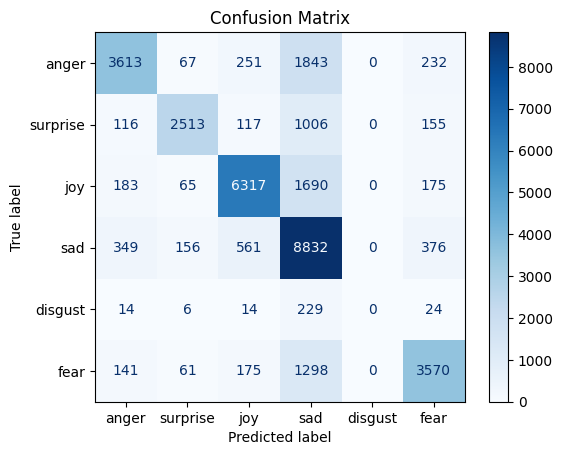

c:\Users\alireza\Desktop\hazm_project\hazm-env\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\alireza\Desktop\hazm_project\hazm-env\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\alireza\Desktop\hazm_project\hazm-env\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capita

              precision    recall  f1-score   support

       anger       0.82      0.60      0.69      6006
    surprise       0.88      0.64      0.74      3907
         joy       0.85      0.75      0.80      8430
         sad       0.59      0.86      0.70     10274
     disgust       0.00      0.00      0.00       287
        fear       0.79      0.68      0.73      5245

    accuracy                           0.73     34149
   macro avg       0.65      0.59      0.61     34149
weighted avg       0.75      0.73      0.73     34149



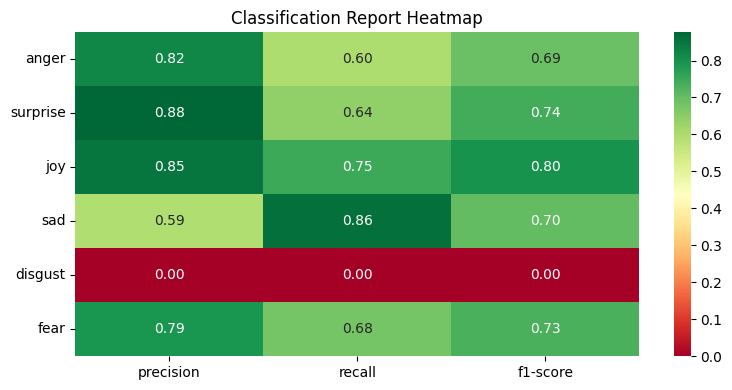

In [ ]:
y_pred = cnn.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

plot_confusion_matrix(y_test, y_pred_classes)
print(classification_report(y_test, y_pred_classes, target_names=class_names))
report = classification_report(y_test, y_pred_classes, target_names=class_names, output_dict=True)

report_df = pd.DataFrame(report).drop(columns=['accuracy', 'macro avg', 'weighted avg'], errors='ignore').T

plt.figure(figsize=(8, 4))
sns.heatmap(report_df[['precision', 'recall', 'f1-score']], annot=True, cmap='RdYlGn', fmt=".2f", cbar=True)
plt.title('Classification Report Heatmap')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()